In [1]:
# Pacotes essenciais
import pandas as pd
import numpy as np
import missingno as msno

# Pacote de plotagem
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Pacotes de pré-processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# APIs para aprendizado de máquina
from mlxtend.frequent_patterns import apriori,association_rules
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# **Introduction**

O presente projeto tem como objetivo analisar os dados de um supermaket visando identificar os produtos mais comprados e os tipos de clientes mais recorrentes deste supermarket, para que com isto seja possível elaborar novas estratégias de vendas de produtos e o direcionamento de publico-alvo para que o marketing possa focar em suas propagandas.

Para isto será utilizado dois datasets, o Market_Basket_Optimisation e o Supermarket_CustomerMembers.

Portanto, neste projeto temos os seguintes objetivos:
- Identificar os tipos de consumidores;
- Identificar os produtos mais e menos vendidos;
- Identificar pares de produtos mais vendidos;
- Elaborar estratégias para aumentar a venda de produtos;

# **Visualization data**

In [3]:
df_products = pd.read_csv("Market_Basket_Optimisation.csv",header=None)
df_customers = pd.read_csv("Supermarket_CustomerMembers.csv")

In [4]:
df_products.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nota-se que para o dataset dos produtos ocorre a presença de dados ausentes devido ao formato em que o dataset foi montado, onde a linha representa o conjunto de produtos comprados.

Neste formato quando uma pessoa compra menos produtos que a anterior ela gera colunas vazias, gerando os dados ausentes.

In [5]:
df_customers.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


No customers dataset não existe a presença de dados ausentes, porém existe uma quantidade menor de dados para serem analisados.

# **Exploratory Data Analysis (EDA)**

Inicialmente será explorado os dados do ‘customers dataset’, visando características importantes e insights relevantes para a formação de grupos, e após isto, será analisado o ‘products dataset’ tendo o objetivo de identificar os produtos mais vendidos e suas características relevantes.

<h2> Customers dataset <h2>

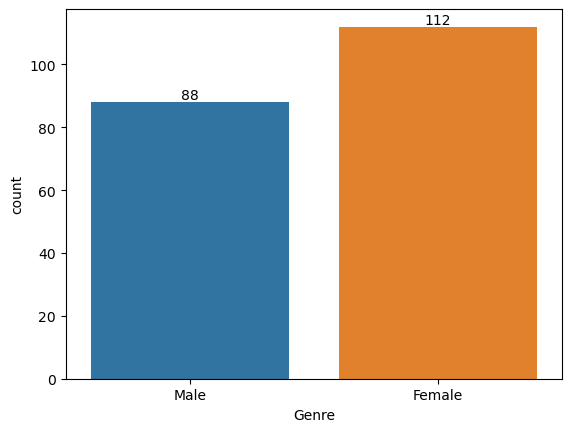

In [9]:
ax = sns.countplot(data = df_customers, x = 'Genre')
ax.bar_label(ax.containers[0])
plt.show()

Pelo gráfico vemos que a maior parcela dos dados dos consumidores desse supermercado é do sexo feminino.

In [15]:
fig = px.violin(df_customers, y="Annual Income (k$)", x = 'Genre', box=True, 
                width = 1100, height = 800, color = "Genre",
                title = 'Distribution of Annual Income based on gender')
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Observando o gráfico nota-se que não existem valores muitos discrepantes de annual income neste dataset. Observando os valores de annual income por gênero nota-se que a média do homem (62,600) é um pouco superior do que a média feminina (60,000).O primeiro quartil para os homens (45,000) é maior que o das mulheres (39,500) indicando que a renda dos homens é um pouco mais concentrada e maior que a das mulheres.

In [19]:
fig = px.violin(df_customers, y="Spending Score (1-100)", x = 'Genre', box=True, 
                width = 1100, height = 800, color = "Genre",
                title = 'Distribution of spending score based on gender')
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Analisando o gráfico nota-se que a média do spending score é a mesma para os dois sexos, porém para o gênero feminino o range entre o primeiro e terceiro quartil é menor que o do gênero masculino, indicando que os dados estão mais concentrados. 

Como o primeiro quartil feminino (35) é maior que o masculino (23) temos a ideia que as mulheres são mais propensas a comprar mais neste supermercado.


In [20]:
fig = px.violin(df_customers, y="Age", x = 'Genre', box=True, 
                width = 1100, height = 800, color = "Genre",
                title = 'Distribution of age based on gender')
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Analisando o gráfico percebe-se que a média das idades das mulheres (35) é menor do que a dos homens (37), além de ter um intervalo de idades mais concentrados (29-48) para as mulheres do que para os homens (27.5-51).

In [21]:
fig = px.scatter_matrix(df_customers,dimensions=["Age","Spending Score (1-100)","Annual Income (k$)"], color = "Genre")
#fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='Supermaket customers Dataset',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',
)
fig.show()

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\Pichau\anaconda3\lib\site-packages\plotly\io\_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Com base nesses gráficos temos as seguintes considerações:
- No gráfico 'Age' x 'Spending Score' nota-se que idades maiores que 40 anos o spending score tende a estar entre o valor de 5 e 60, enquanto para idades menores que 40 anos o spending score oscila entre 20 a 100.
- No gráfico 'Age' x 'Annual Income' os maiores valores de income são encontrados na faixa de indade entre 28 à 54 anos. Para idades abaixo de 28 e acima de 54 o valor de income geralmente encontrado é abaixo de 88,000.
- No gráfico de 'Spending Score' x 'Annual Income' nota-se a formação de 5 grupos diferentes: 
    - Um grupo onde possui um valor alto de income (70,000 à 137,000) mas com spending score baixo, entre 1 à 40.
    - Um grupo onde possui um valor alto de income (70,000 à 137,000) e com spending score alto, entre 63 à 97.
    - Um grupo onde possui um valor baixo de income (16,000 à 38,000) e com spending score alto, entre 60 à 98.
    - Um grupo onde possui um valor baixo de income (16,000 à 38,000) e com spending score baixo, entre 3 à 40.
    - Um grupo com valores medianos de income (40,000 à 65,000) e de spending score (40 à 60).
    
    
Com base nestas informações a expectativa é que ocorra a geração de aproximadamente de 4 a 6 grupos de consumidores baseado nestes dados tendo como features principais o spending score e o annual income.

<h2> Product dataset <h2>

Inicialmente é necessário realizar um feature engineering no dataset a fim retirar informações relevantes dele.

In [22]:
products = df_products.values.tolist()
name_col =['ID_client','item_description']
df_prod = pd.DataFrame(columns=name_col)
for i in range(len(products)):
    buy_list = set(products[i])
    for j in buy_list:
        n = len(df_prod.index)
        df_prod.loc[n,'ID_client'] = i
        df_prod.loc[n,'item_description'] = j

df_prod.dropna(inplace = True)

In [26]:
list_products = set()
for i in range(len(products)):
    list_products = set(products[i]) | list_products
    
list_products = list(list_products)
list_products.pop(0)
list_products.append('Count_products')
aa =np.zeros((len(products),len(list_products)))
df_prod2 = pd.DataFrame(aa, columns = list_products)

for i in range(len(products)-1):
    buy_list = set(products[i])
    for j in range(len(list_products)-1):
        for k in buy_list:
            if list_products[j] == k:
                df_prod2.iloc[i,j] = 1 + df_prod2.iloc[i,j]

    df_prod2.iloc[i,len(list_products)-1] = df_prod2.iloc[i,0:len(list_products)-2].sum()
    
pd.set_option('display.max_columns', None)

In [27]:
df_prod2.shape

(7501, 121)

In [28]:
df_prod2.describe()

,rice,cake,frozen vegetables,carrots,blueberries,cauliflower,pasta,whole weat flour,eggplant,ketchup,burger sauce,tomato sauce,salt,frozen smoothie,black tea,parmesan cheese,red wine,pepper,yogurt cake,oil,ground beef,bramble,sandwich,bug spray,mineral water,low fat yogurt,tea,herb & pepper,salad,green grapes,light cream,barbecue sauce,light mayo,dessert wine,olive oil,meatballs,spinach,strong cheese,fresh bread,soup,extra dark chocolate,strawberries,water spray,tomatoes,spaghetti,cider,pickles,bacon,brownies,eggs,almonds,chocolate bread,ham,sparkling water,shrimp,burgers,antioxydant juice,asparagus,french wine,toothpaste,clothes accessories,babies food,napkins,chocolate,mashed potato,zucchini,soda,chutney,fresh tuna,melons,gluten free bar,gums,green tea,vegetables mix,energy bar,cream,oatmeal,pet food,corn,salmon,white wine,chicken,mint green tea,fromage blanc,flax seed,grated cheese,muffins,butter,hot dogs,body spray,shampoo,chili,whole wheat pasta,french fries,mushroom cream sauce,cooking oil,milk,nonfat milk,turkey,escalope,cereals,avocado,whole wheat rice,tomato juice,protein bar,pancakes,magazines,shallot,cottage cheese,honey,champagne,yams,hand protein bar,energy drink,candy bars,cookies,mint,asparagus,green beans,mayonnaise,Count_products
count,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.00000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000,7501.000000
mean,0.018797,0.081056,0.095321,0.015331,0.009199,0.004799,0.015731,0.009332,0.013198,0.004399,0.005866,0.014131,0.009199,0.063192,0.014265,0.019864,0.028130,0.026530,0.027196,0.023064,0.098254,0.001866,0.004533,0.008666,0.238368,0.076390,0.003866,0.049460,0.004933,0.009065,0.015598,0.010799,0.027196,0.004399,0.065858,0.020931,0.007066,0.007732,0.043061,0.050527,0.011998,0.021330,0.000400,0.068391,0.174110,0.010532,0.005999,0.008666,0.033729,0.179576,0.020397,0.004266,0.026530,0.006266,0.071457,0.087188,0.008932,0.000133,0.02253,0.008132,0.008399,0.004533,0.000667,0.163845,0.004133,0.009465,0.006266,0.004133,0.022264,0.011998,0.006932,0.013465,0.132116,0.025730,0.027063,0.000933,0.004399,0.006532,0.004799,0.042528,0.016531,0.059992,0.005599,0.013598,0.009065,0.052393,0.024130,0.030129,0.032396,0.011465,0.004933,0.006133,0.029463,0.170911,0.019064,0.051060,0.129583,0.010399,0.062525,0.079323,0.025730,0.033329,0.058526,0.030396,0.018531,0.095054,0.010932,0.007732,0.031862,0.047460,0.046794,0.011465,0.005199,0.026663,0.009732,0.080389,0.017464,0.004666,0.008666,0.006133,3.907212
std,0.135818,0.272939,0.293677,0.122875,0.095474,0.069116,0.124442,0.096157,0.114131,0.066186,0.076369,0.118041,0.095474,0.243323,0.118588,0.139542,0.165354,0.160715,0.162666,0.150116

Analisando a tabela temos que:
- Existem 121 produtos únicos neste dataset.
- Não existe a repetição de um mesmo item em uma única compra.
- Em média um consumidor compra 4 produtos.
- O maior número de produtos comprados em uma única vez foi 20.

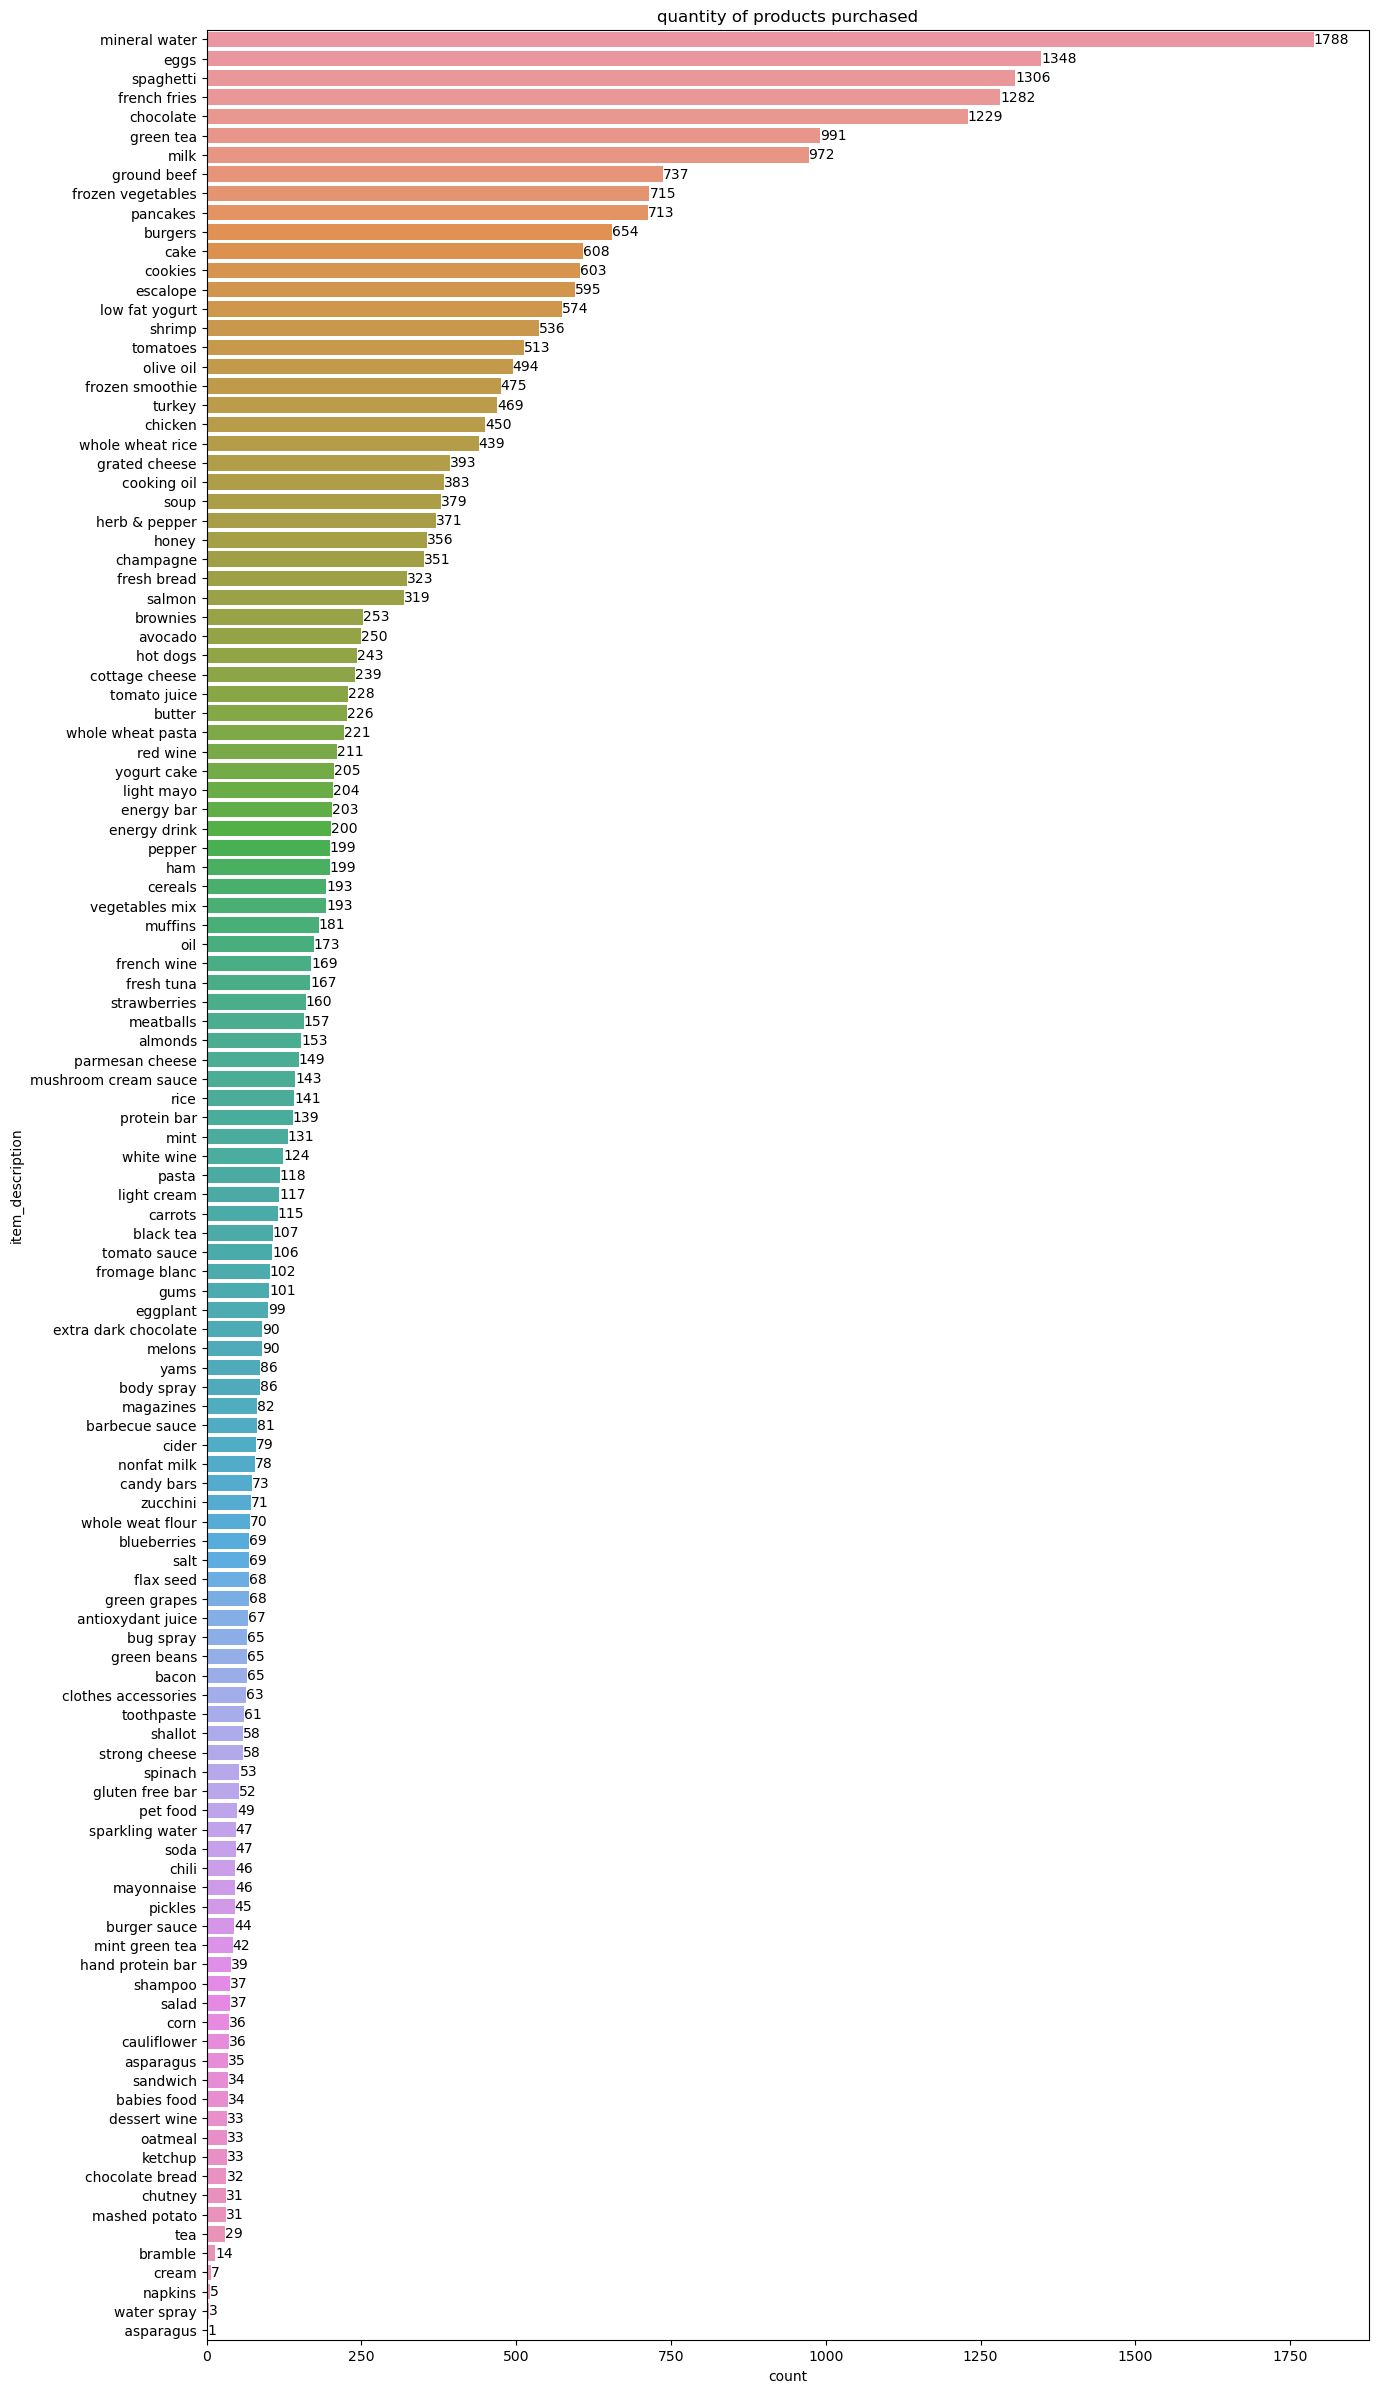

In [22]:
plt.figure(figsize=(15,30))
ax = sns.countplot(data= df_prod, y= 'item_description',order = df_prod['item_description'].value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title("quantity of products purchased")
plt.show()

Com base no gráfico os top 10 itens mais comprados são:
- mineral water, eggs, spaghetti, french fries, chocolate, green tea, milk, ground beef, frozen vegetagles, pancakes.

Destes itens, a sua maioria é composta por itens de consumo diário e por itens de breakfast.

Os top 10 itens menos comprados são:
- asparagus, water spray, napkins, cream, bramble, tea, mashed potato, chutney, chocolate bread,dessert wine.

Alguns destes itens são considerados itens de limpeza, de sobremesa e vegetais, porém não parece existir um padrão visível entre eles para que ocorra a sua baixa demanda.

Para identificar os pares de produtos mais comprados será utilizado as regras de associação.

# **Association rules - products purchased**

<h2> Main concepts <h2>

Para compreender as regras de associação, é necessário compreender quatro conceitos fundamentais: 

- Suporte: O suporte é uma indicação da frequência com que o conjunto de itens aparece no conjunto de dados. Em outras palavras, isso é uma indicação da popularidade de um conjunto de itens em um conjunto de dados. 

- Confiança: A confiança é uma indicação de quantas vezes a regra foi considerada verdadeira. Em outras palavras, a confiança indica a probabilidade de compra do item Y quando o item X é comprado. 

- Lift: O Lift é uma métrica para medir a proporção entre X e Y que ocorrem juntos e a ocorrência de X e Y se eles fossem estatisticamente independentes. Em outras palavras, o lift ilustra a probabilidade de o item Y ser comprado quando o item X é comprado, ao mesmo tempo que controla a popularidade do item Y. 
    - Uma pontuação de Lift próxima de 1 indica que o antecedente e o consequente são independentes e a ocorrência do antecedente não tem impacto na ocorrência do consequente. 
    - Uma pontuação de Lift maior que 1 indica que o antecedente e o consequente são dependentes um do outro, e a ocorrência do antecedente tem um impacto positivo na ocorrência do consequente.
     - Uma pontuação de Lift menor que 1 indica que o antecedente e o consequente se substituem, o que significa que a existência do antecedente tem um impacto negativo no consequente ou vice-versa. 

- Convicção: A convicção mede a força de implicação da regra a partir da independência estatística. A pontuação de convicção é uma razão entre a probabilidade de X ocorrer sem Y enquanto eles eram dependentes e a probabilidade real de existência de X sem Y.



In [23]:
df_prod2.drop(columns = ['Count_products'],inplace = True)
freq_item = apriori(df_prod2, min_support=0.01, use_colnames=True)
freq_item['length'] = freq_item['itemsets'].apply(lambda x: len(x))
freq_item

,support,itemsets,length
0,0.033329,(avocado),1
1,0.071457,(shrimp),1
2,0.016531,(white wine),1
3,0.079323,(escalope),1
4,0.013598,(fromage blanc),1
...,...,...,...
252,0.013465,"(eggs, chocolate, mineral water)",3
253,0.013998,"(milk, chocolate, mineral water)",3
254,0.013065,"(eggs, milk, mineral water)",3
255,0.010532,"(eggs, chocolate, spaghetti)",3


Com base no valor mínimo de suporte escolhido de 1% temos que no máximo ocorre a formação de um grupo composto por 3 itens.

In [24]:
freq_item[ (freq_item['length'] == 2) & (freq_item['support'] >= 0.04) ]

,support,itemsets,length
99,0.040928,"(ground beef, mineral water)",2
102,0.059725,"(spaghetti, mineral water)",2
105,0.052660,"(chocolate, mineral water)",2
107,0.050927,"(eggs, mineral water)",2
114,0.047994,"(milk, mineral water)",2


Observando os pares de itens gerados com um valor de suporte maior que 4% tem-se que em todos os casos existe a presença do item 'mineral water'.

Também é perceptível que todos estes pares são gerados com os top 10 itens comprados neste supermarket.

In [25]:
freq_item[ (freq_item['length'] == 3) ]

,support,itemsets,length
240,0.017064,"(ground beef, spaghetti, mineral water)",3
241,0.010932,"(chocolate, ground beef, mineral water)",3
242,0.010132,"(eggs, ground beef, mineral water)",3
243,0.011065,"(milk, ground beef, mineral water)",3
244,0.010132,"(french fries, spaghetti, mineral water)",3
245,0.011998,"(frozen vegetables, spaghetti, mineral water)",3
246,0.015865,"(chocolate, spaghetti, mineral water)",3
247,0.014265,"(eggs, spaghetti, mineral water)",3
248,0.015731,"(milk, spaghetti, mineral water)",3
249,0.011465,"(pancakes, spaghetti, mineral water)",3


Observando a tabela gerada composta pela associação de três itens, nota-se novamente a presença do item 'mineral water' em quase todos os grupos formados.

In [26]:
rules = association_rules(freq_item, metric="lift", min_threshold=1.3)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("confidence",ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
218,"(eggs, ground beef)",(mineral water),0.019997,0.238368,0.010132,0.506667,2.125563,0.005365,1.543848,2,1
224,"(milk, ground beef)",(mineral water),0.021997,0.238368,0.011065,0.503030,2.110308,0.005822,1.532552,2,1
212,"(ground beef, chocolate)",(mineral water),0.023064,0.238368,0.010932,0.473988,1.988472,0.005434,1.447937,2,1
270,"(milk, frozen vegetables)",(mineral water),0.023597,0.238368,0.011065,0.468927,1.967236,0.005440,1.434136,2,1
54,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,0.011020,1.401255,1,1
258,"(pancakes, spaghetti)",(mineral water),0.025197,0.238368,0.011465,0.455026,1.908923,0.005459,1.397557,2,1
264,"(olive oil, spaghetti)",(mineral water),0.022930,0.238368,0.010265,0.447674,1.878079,0.004799,1.378954,2,1
252,"(milk, spaghetti)",(mineral water),0.035462,0.238368,0.015731,0.443609,1.861024,0.007278,1.368879,2,1
282,"(milk, chocolate)",(mineral water),0.032129,0.238368,0.013998,0.435685,1.827780,0.006340,1.349656,2,1
206,"(ground beef, spaghetti)",(mineral water),0.039195,0.238368,0.017064,0.435374,1.826477,0.007722,1.348914,2,1


Observando a tabela é possível perceber existe uma grande tendência do item 'mineral water' ser o terceiro item a ser comprado.

Pela tabela vemos uma grande presença dos itens 'ground beef', 'spaghetti' e 'milk' como antecedentes que possuem maior valor de confiança, porém em sua maior parte são comprados em pares para depois resultar na compra de 'mineral water'. Em geral todos esses casos estas hipóteses possuem valores de lift e convicção altos, reforçando a confiabilidade desta regra.


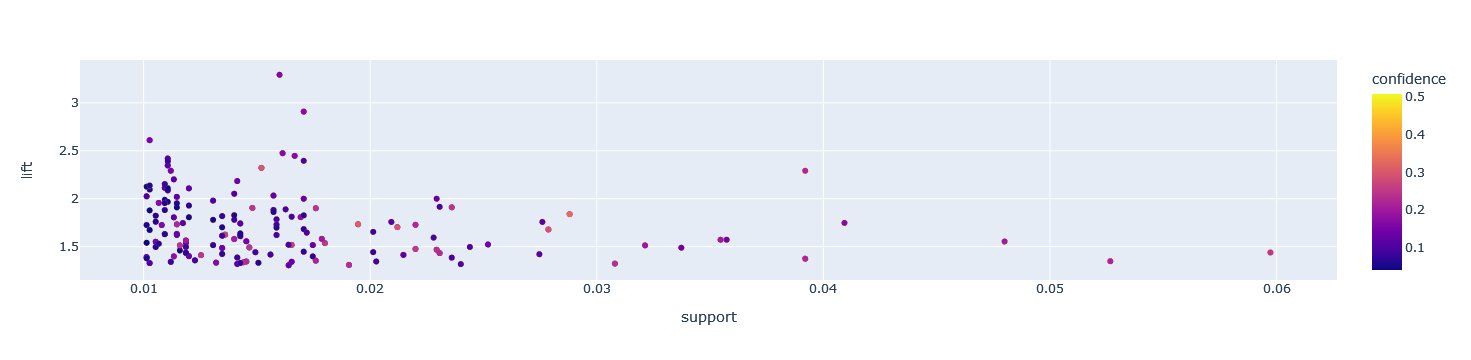

In [27]:
px.scatter(rules, x ='support', y =  'lift', color = 'confidence')

Observando o gráfico temos que a maioria das regras criadas possui lift maior que 1 e valor de confiança menor que 50%. Isto nos dá a ideia de que as regras criadas possuem bastante força, mas que algumas não tem uma ocorrência forte nas listas de compras examinadas.

In [28]:
rules[ (rules['antecedents_length'] == 1) ].sort_values("confidence",ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
54,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,0.011020,1.401255,1,1
60,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,0.011898,1.310962,1,1
34,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401,1,1
24,(salmon),(mineral water),0.042528,0.238368,0.017064,0.401254,1.683336,0.006927,1.272045,1,1
36,(cereals),(mineral water),0.025730,0.238368,0.010265,0.398964,1.673729,0.004132,1.267198,1,1
118,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997,1,1
46,(cooking oil),(mineral water),0.051060,0.238368,0.020131,0.394256,1.653978,0.007960,1.257349,1,1
26,(red wine),(mineral water),0.028130,0.238368,0.010932,0.388626,1.630358,0.004227,1.245770,1,1
38,(chicken),(mineral water),0.059992,0.238368,0.022797,0.380000,1.594172,0.008497,1.228438,1,1
42,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,0.013007,1.218270,1,1


Olhando a tabela que leva em consideração a compra de somente 1 item como antecessor, percebe-se a forte presença do item 'mineral water' novamente.

Um outro produto que foge um pouco desta regra é o item 'ground beef' com o 'spaghetti' possuindo um valor de confiança de cerca de 40% juntamente com um lift muito elevado de 2.3.


In [29]:
rules[ (rules['antecedents_length'] == 1) & (rules['consequents_length'] == 1) ].sort_values("confidence",ascending=True).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
37,(mineral water),(cereals),0.238368,0.025730,0.010265,0.043065,1.673729,0.004132,1.018115,1,1
27,(mineral water),(red wine),0.238368,0.028130,0.010932,0.045861,1.630358,0.004227,1.018584,1,1
1,(mineral water),(avocado),0.238368,0.033329,0.011598,0.048658,1.459926,0.003654,1.016113,1,1
93,(spaghetti),(red wine),0.174110,0.028130,0.010265,0.058959,2.095966,0.005368,1.032761,1,1
49,(mineral water),(honey),0.238368,0.047460,0.015065,0.063199,1.331619,0.003752,1.016801,1,1
91,(chocolate),(salmon),0.163845,0.042528,0.010665,0.065094,1.530617,0.003697,1.024137,1,1
151,(spaghetti),(honey),0.174110,0.047460,0.011865,0.068147,1.435873,0.003602,1.022200,1,1
184,(eggs),(herb & pepper),0.179576,0.049460,0.012532,0.069785,1.410930,0.003650,1.021849,1,1
66,(chocolate),(champagne),0.163845,0.046794,0.011598,0.070789,1.512793,0.003932,1.025824,1,1
51,(mineral water),(herb & pepper),0.238368,0.049460,0.017064,0.071588,1.447397,0.005275,1.023835,1,1


Observando as regras que possuem somente um item de antecessor e um item de consequência com o menor valor de confiança tem-se que quando a pessoa compra 'mineral water' ela tem baixa chance de comprar junto itens como 'cereals', 'red wine' e 'avocado'.

Nota-se também que essas regras apresentadas relacionam itens de maior demanda como itens antecessores e itens de média demanda como consequência.

# **Customer segmentation - Clustering**

Para a elaboração do modelo de machine learning de clusterização dos grupos de clientes será utilizado o modelo K-means, por ser um modelo amplamente utilizado para esta aplicação. 

Com base nisto será realizado o escalonamento das variáveis, sendo o gênero classificado em 0 e 1 e as demais variáveis (‘Age’, ‘Income’, ‘Spending score’) com um Scaler **‘MinMax’**, para melhorar o desempenho do algoritmo de clusterização.


<h2> Scaling data <h2>

In [30]:
df_customers.drop('CustomerID', axis=1, inplace = True)
label_encoder = LabelEncoder()
data_scaler = df_customers.copy()
data_scaler['Genre'] = label_encoder.fit_transform(df_customers['Genre'])
scaler = MinMaxScaler()
data_scaler = pd.DataFrame(scaler.fit_transform(data_scaler),columns=df_customers.columns)
data_scaler

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.008197,0.051020
3,0.0,0.096154,0.008197,0.775510
4,0.0,0.250000,0.016393,0.397959
...,...,...,...,...
195,0.0,0.326923,0.860656,0.795918
196,0.0,0.519231,0.909836,0.275510
197,1.0,0.269231,0.909836,0.744898
198,1.0,0.269231,1.000000,0.173469


In [31]:
data_scaler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genre                   200 non-null    float64
 1   Age                     200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Spending Score (1-100)  200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


<h2> K-means model <h2>

Para a implementação do modelo k-means inicialmente deve ser selecionado a quantidade de grupos a serem gerados. Para isto será utilizado quatro critérios diferentes para identificar a quantidade de clusters que devem ser gerados. Os critérios em questão são:
- The Elbow method, based in inertia.
- Silhouette criterion.
- Calinski and Harabasz criterion.
- Davies and Bouldin criterion.

Uma simples explicação dos ultimos três critérios pode ser encontrada no seguinte link: [How to measure clustering performances](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c).

In [32]:
# Avaliando o número de clusters utilizados no K-means
wcss = []
sil = []
CeH = []
DeB = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(data_scaler)
    # Calculando as métricas
    aux1 = silhouette_score(data_scaler, kmeans.labels_)
    aux2 = calinski_harabasz_score(data_scaler, kmeans.labels_)
    aux3 = davies_bouldin_score(data_scaler, kmeans.labels_)
    # Armazenando os valores das métricas calculadas
    wcss.append(kmeans.inertia_)
    sil.append(aux1)
    CeH.append(aux2)
    DeB.append(aux3)

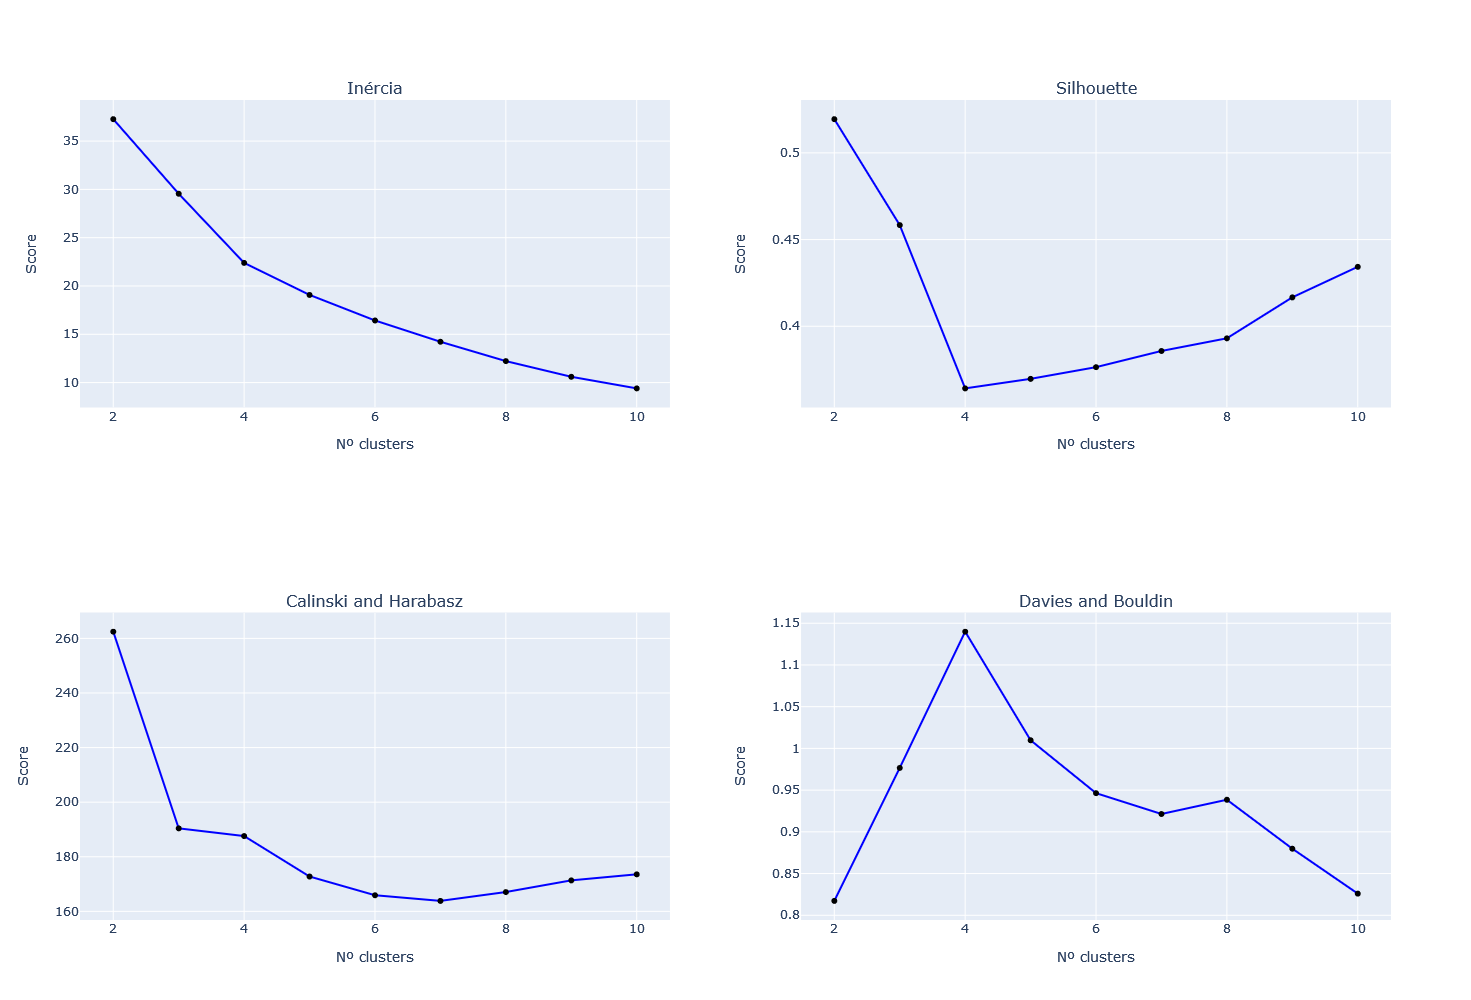

In [33]:
# Criando os gráficos das métricas

figu = make_subplots(rows = 2, cols = 2,subplot_titles=("Inércia", "Silhouette", "Calinski and Harabasz", "Davies and Bouldin"))
# Add traces
X = np.arange(2,21)
figu.add_trace(
    go.Scatter(x = X, y = wcss,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=1)
figu.add_trace(
    go.Scatter(x = X, y = sil,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=2)
figu.add_trace(
    go.Scatter(x = X, y = CeH,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=1)
figu.add_trace(
    go.Scatter(x = X, y = DeB,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=2)

# Update xaxis properties
figu.update_xaxes(title_text="Nº clusters", row=1, col=1)
figu.update_xaxes(title_text="Nº clusters", row=1, col=2)
figu.update_xaxes(title_text="Nº clusters", row=2, col=1)
figu.update_xaxes(title_text="Nº clusters", row=2, col=2)

# Update yaxis properties
figu.update_yaxes(title_text="Score", row=1, col=1)
figu.update_yaxes(title_text="Score", row=1, col=2)
figu.update_yaxes(title_text="Score", row=2, col=1)
figu.update_yaxes(title_text="Score", row=2, col=2)
figu.update_layout(showlegend=False,height=1000, width=1000)
figu.show()

Observando os gráficos tem-se que:
- Para o critério de inércia ocorre um ponto suave de inflexão com 4 clusters.
- Para o critério de Silhouette o ponto que apresenta o maior valor de score é o que possui 2 clusters.
- Para o critério de Calinski and Harabasz o gráfico não apresenta um ponto de inflexão positivo, logo não existe um valor de clusters por meio deste critério.
- Pelo critério de Davis and Bouldin o ponto que apresenta menor valor de score é o que possui 2 clusters.

Com estes resultados temos que será gerado uma segmentação com 2 cluster ou com 4 clusters. Na minha opinião dois clusters não seriam significativos, visto que o dataset possui poucos dados e poucas features, assim provavelmente ocorreu uma segregação por meio de dois grupos de renda ou spending score.

Portanto será utilizado a clusterização com 4 clusters no decorrer das análises.


<h2> Cluster vizualization - PCA <h2>

Após o processo de clusterização é necessário a realização de uma verificação visual e analítica sobre os grupos gerados, visto que essa é uma técnica de aprendizado não supervisionada. Para isso, pode-se utilizar as próprias variáveis do dataset para tentar realizar a visualização e entendimento desses clusters, porém é complexo identificar quais seriam as principais variáveis a serem utilizadas neste processo.

Com o intuito de ter uma melhor explicabilidade dos clusters gerados, será utilizado a técnica do 'PCA' (Análise dos Componentes Principais). Esta técnica tem como objetivo a redução de dimensionalidade (quantidade de variáveis) de um dataset por meio da criação de novas variáveis que expliquem de maneira satisfatória os dados originais. 

Portanto, a utilização desta técnica tem como objetivo criar novas dimensões para uma melhor visualização dos clusters gerados

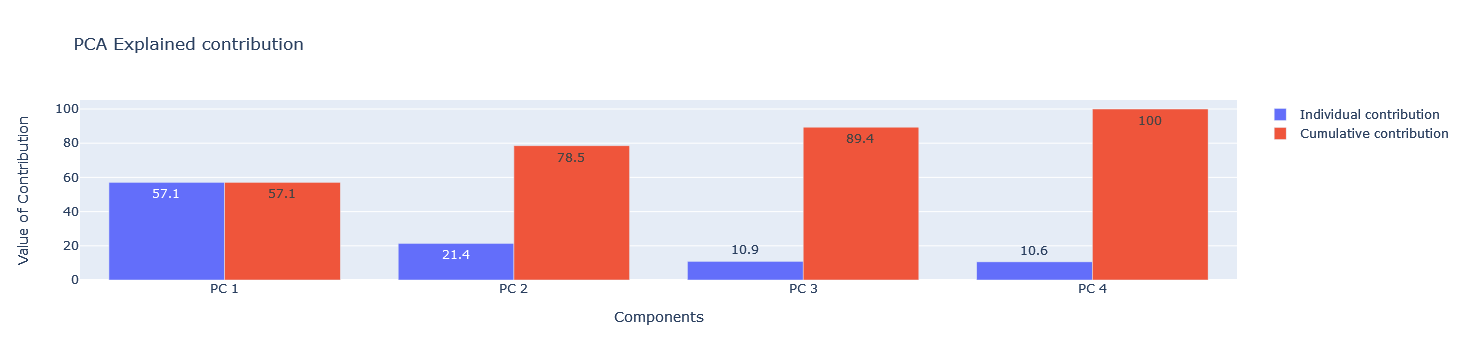

In [34]:
pca = PCA()
pca_components = pca.fit(data_scaler)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var_cumulative = np.zeros(len(var))
var_cumulative[0] = var[0]
for i in range(1,len(var)):
    var_cumulative[i] = var[i]+var_cumulative[i-1]

labels = [
    f"PC {i+1}"
    for i in range(0,len(var))
]

fig = go.Figure()
fig.add_trace(go.Bar(
    x = labels,
    y= var,
    text = var,
    name='Individual contribution'))

fig.add_trace(go.Bar(
    x = labels,
    y = var_cumulative,
    text = var_cumulative,
    name ='Cumulative contribution'))

fig.update_layout(barmode='group',
                  title="PCA Explained contribution",
                  xaxis_title="Components",
                  yaxis_title="Value of Contribution")

fig.show()

Observando o gráfico nota-se que a explicabilidade do dados com três componentes é de 89,4% sendo um valor razoável para a vizualização dos dados.

In [35]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(data_scaler)
df_customers['class'] = kmeans.labels_
data_scaler['class'] = df_customers['class']

for i in range(0,max(kmeans.labels_)+1):
    var = 'class '+ str(i+1)
    df_customers['class'] = df_customers['class'].replace(i,var)

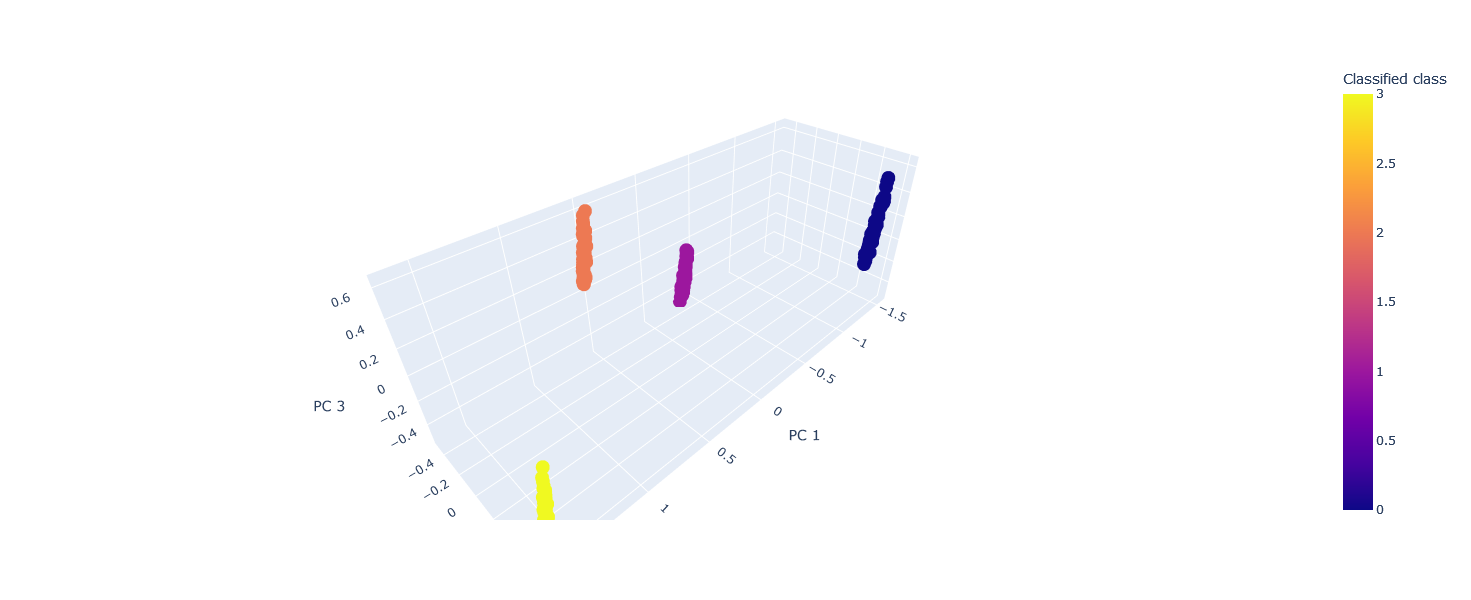

In [36]:
pca = PCA(3)
pca_components=pca.fit(data_scaler)
scores_pca = pca.transform(data_scaler)
pca_data = pd.DataFrame(scores_pca, columns=['PC 1','PC 2','PC 3']) 
pca_data['class'] = data_scaler['class']

fig = px.scatter_3d(pca_data,x = 'PC 1', y = 'PC 2', z = 'PC 3' ,color='class',width=1200,height = 600, labels={"class":"Classified class"})
fig.show()

Analisando o gráfico nota-se que os quatro grupos gerados estão bem isolados, mostrando que a clusterização foi eficiente.

## Avaliando clusters

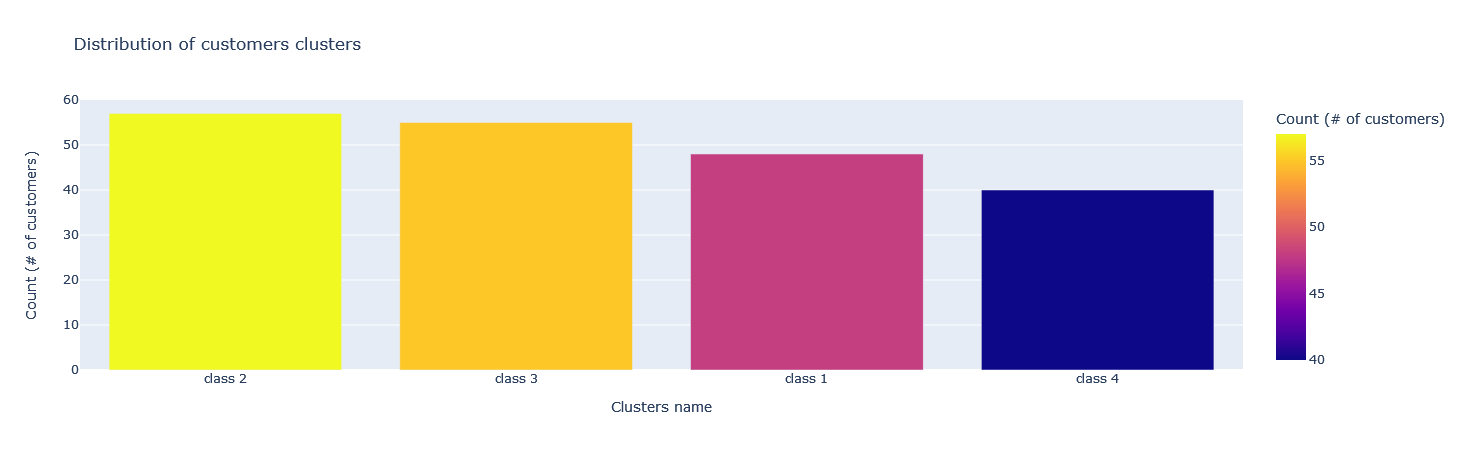

In [37]:
fig = px.bar(df_customers['class'].value_counts(), 
             y = "class", color = 'class',
            width = 600, height = 450,
            labels={"class": "Count (# of customers)",
                     "index": "Clusters name"},
                title="Distribution of customers clusters")
fig.show()

Pelo gráfico nota-se que a estão bens distribuídas, sendo a classe 2 com a maior quantidade de dados (57) e a classe 4 com a menor quantidade de dados (40).

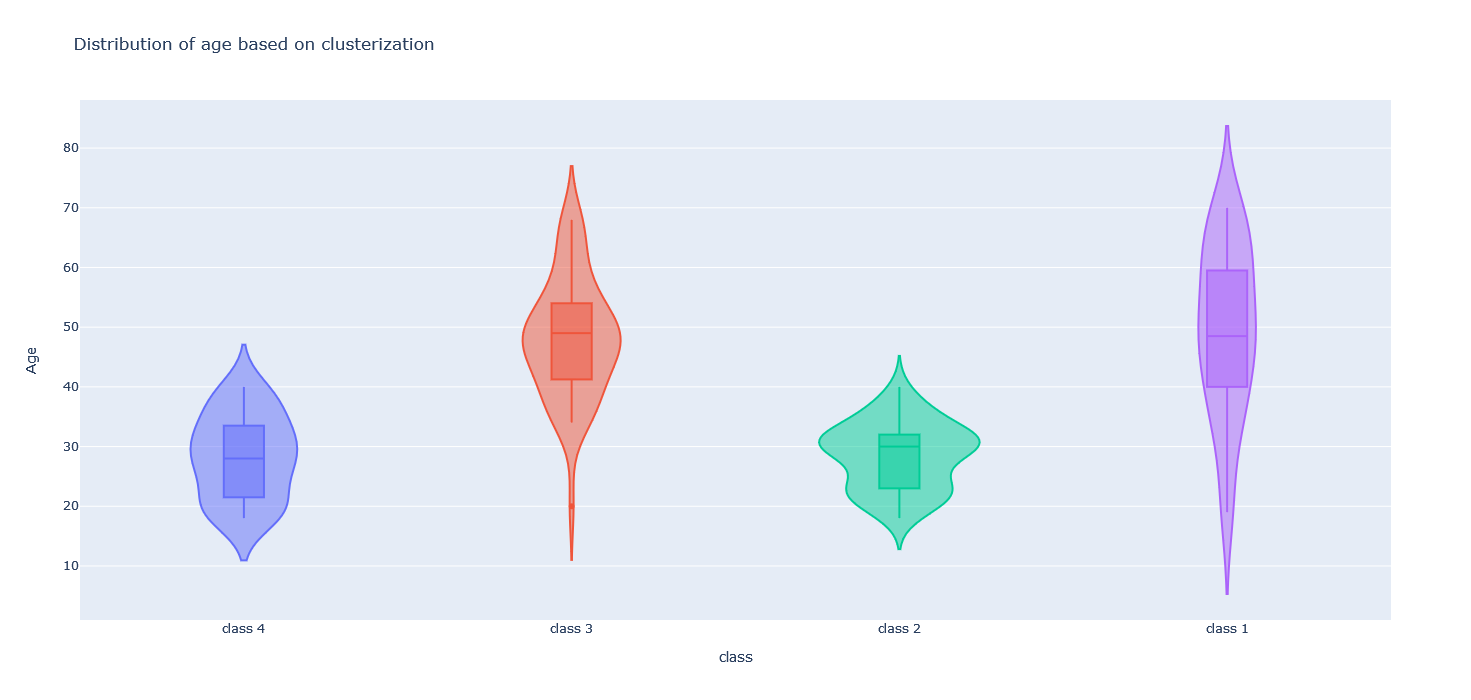

In [38]:
fig = px.violin(df_customers, y="Age", x = 'class', box=True, 
                width = 900, height = 700, color = "class",
                title = 'Distribution of age based on clusterization')
fig.update_layout(showlegend=False)
fig.show()

Analisando o gráfico temos:
- As classes 2 e 4 pertencem à um grupo de pessoas mais jovens, girando em torno de 18 à 40 anos.
- A classe 2 possui uma grande concentração de pessoas na faixa dos 30 anos.
- A classe 3 pertence à um grupo de pessoas adultas e idosos, indo de 34 anos até 68 anos, sendo mais concentrada na faixa de 41 à 54 anos.
- a classe 1 engloba uma faixa alta de idades, indo de 19 anos até 70 anos, onde em média a pessoa possui 49 anos.

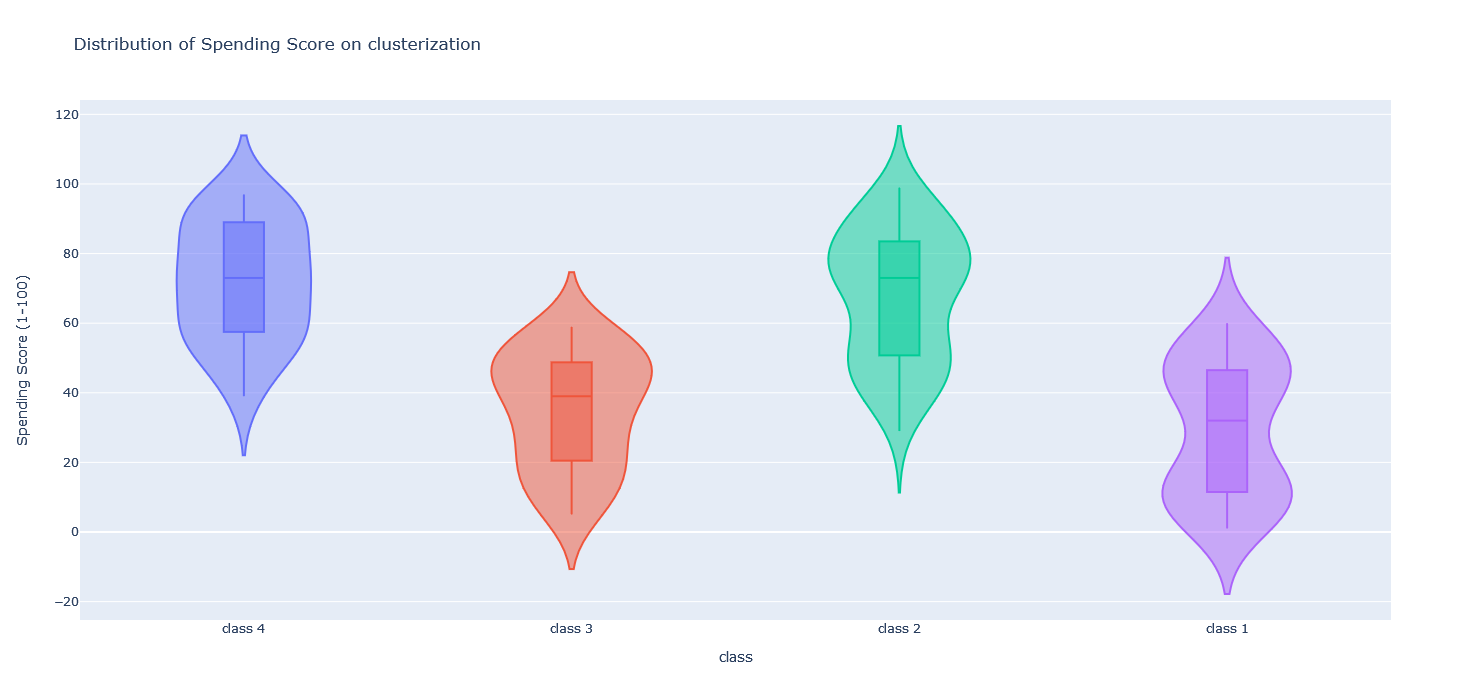

In [39]:
fig = px.violin(df_customers, y="Spending Score (1-100)", x = 'class', box=True, 
                width = 900, height = 700, color = "class",
                title = 'Distribution of Spending Score on clusterization')
fig.update_layout(showlegend=False)
fig.show()

Com base nesse gráfico é possível concluir:
- A classe 4 representa um grupo que tem a tendência a gastar mais em suas compras, possuindo em sua maioria um spending score entre 58 e 89.
- A classe 3 representa um grupo de pessoas que não tende a gastar muito, variando o spending score de 5 à 60, porém sendo mais concentrado na faixa de 39 a 50.
- A classe 2 também representa um grupo de pessoas que gastam mais, porém neste caso o spending score é mais concentrado entre o valor de 62 e 93.
- A classe 1 representa um grupo de pessoas que em geral não gastam muito, tendo dois intervalos de concentração, um com spending score variando entre 1 e 25 e outro intervalo indo de 32 até 60.

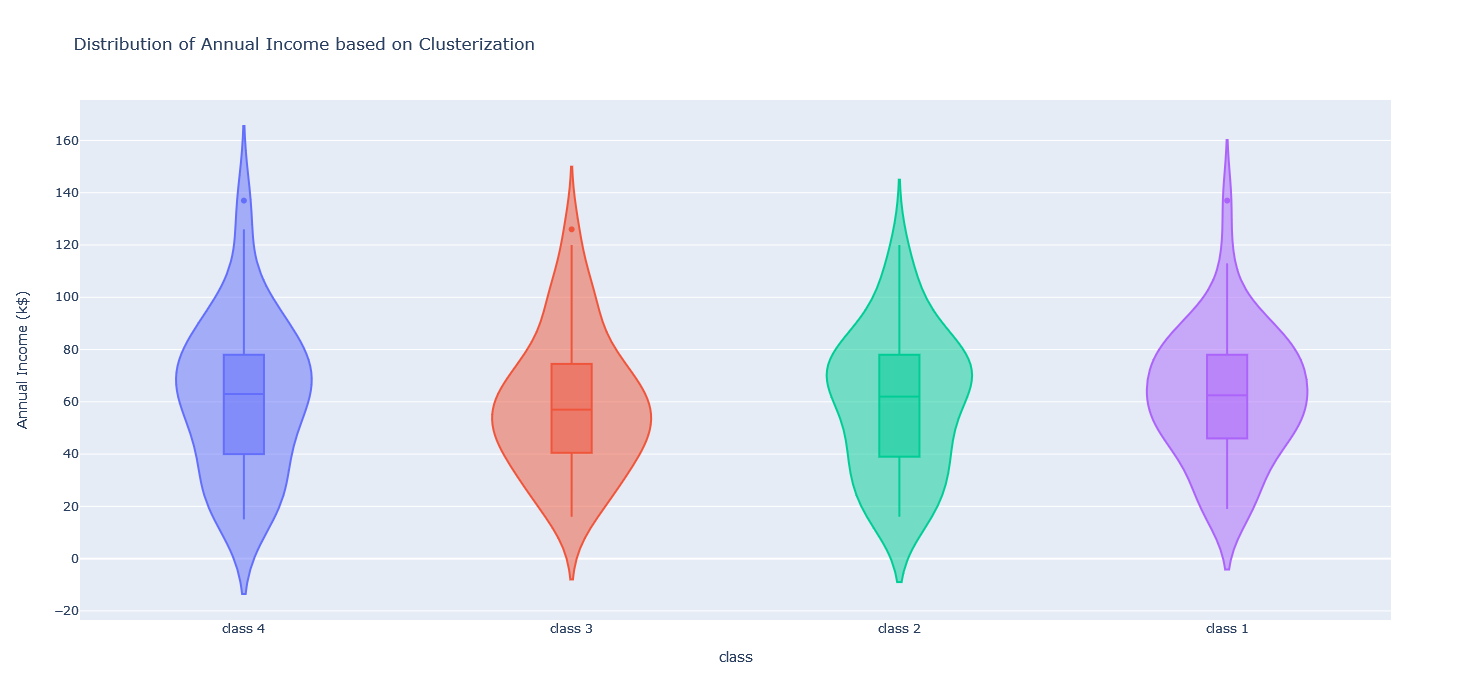

In [40]:
fig = px.violin(df_customers, y="Annual Income (k$)", x = 'class', box=True, 
                width = 900, height = 700, color = "class",
                title = 'Distribution of Annual Income based on Clusterization')
fig.update_layout(showlegend=False)
fig.show()

Observando o gráfico não é possível perceber uma diferença entre o annual income de cada classe.

<AxesSubplot:xlabel='class', ylabel='count'>

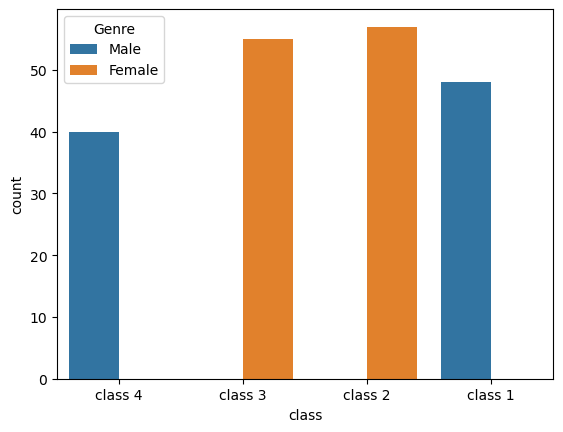

In [41]:
sns.countplot(data= df_customers, x = 'class', hue ='Genre')

Neste gráfico nota-se que as classes 4 e 1 são compostos por pessoas do sexo masculino enquanto as classes 3 e 2 são compostos pelas pessoas do sexo feminino.

# **Conclusion**

Na segmentação dos clientes foram identificados quatro grupos distintos de compradores, nos quais os principais a serem focados são os grupos 1 e 3, visto que os grupos em si possuem annual income relativamente similar, mas estes dois grupos possuem valores de spending score menores que 60. 

Como esses dois grupos são formados por homens com idades na faixa de 40 à 60 anos, o ideal é identificar quais são os produtos mais comprados e mais desejados desses tipos de consumidores para elaborar estratégias de marketing focando neste público e em alguns casos concedendo descontos em compras com programas de fidelidade para tentar impulsionar o número de vendas.

Em relação aos produtos mais vendidos foram identificados os seguintes itens:
- Mineral water, eggs, spaghetti, french fries, chocolate, green tea, milk, ground beef, frozen vegetagles, pancakes.

Destes itens, a sua maioria é composta por itens de consumo diário e por itens de breakfast.

Os top 10 itens menos comprados são:
- asparagus, water spray, napkins, cream, bramble, tea, mashed potato, chutney, chocolate bread,dessert wine.

Alguns destes itens são considerados itens de limpeza, de sobremesa e vegetais, porém não parece existir um padrão visível entre eles para que ocorra a sua baixa demanda. Como o dataset de produtos comprados é considerado relativamente pequeno não existe uma ocorrência significativa dos produtos menos comprados, como por exemplo 'asparagus' foi comprado somente 1 vez em 7500 compras, com isso não é possível realizar uma análise confiável visando aumentar o número de vendas desses produtos.

visando aumentar o número de vendas nota-se que das regras de associação criadas o produto 'mineral water' tem um grande impacto como item consequente tanto após compras com um ou dois itens, além de ser o produto mais vendido da loja. Analisando os itens com menor confiança entre as compras com dois itens o 'mineral water' é geralmente o primeiro item a ser comprado, indicando que quando a pessoa compra este item ela tende a não comprar outros itens como 'cereals', 'red wine' e 'avocado', que são itens de média demanda.

Com base nisto uma estratégia que pode ser implementada é alocar o produto 'mineral water' no fim dos corredores desta loja, onde nestes corredore podem se encontrar produtos como itens 'ground beef', 'spaghetti' e 'milk', que são itens que possuem uma confiança e suporte altos de antecessores do item de 'mineral water'. Isto também pode ocasionar no aumento de venda de outros itens, visto que 'mineral water' é o produto de maior demanda os consumidores podem acabar comprando outros produtos no meio do trajeto até este item.
